In [1]:
import gym
import numpy as np
from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import EvalCallback, BaseCallback
from stable_baselines3.common.env_checker import check_env
from env_single1 import DistributedConsensusEnv

# 确保环境符合Gym的规范
env = DistributedConsensusEnv(num_iterations=20000, dt=0.001)
check_env(env)

# 创建训练环境实例
train_env = DistributedConsensusEnv()

# 创建评估环境实例
eval_env = DistributedConsensusEnv()

# 定义PPO模型，您可以根据需求调整超参数
model = PPO(
    "MlpPolicy",    # 使用多层感知器的策略网络
    train_env,      # 自定义环境
    verbose=1,      # 输出训练信息
    #tensorboard_log="./ppo_consensus_d_f_tensorboard/"  # 日志存储路径（可选）
    tensorboard_log="./ppo_consensus_d_f_tensorboard_single/"  # 日志存储路径（可选）
)

class TriggerCountCallback(BaseCallback):
    def __init__(self, verbose=0):
        super(TriggerCountCallback, self).__init__(verbose)
    
    def _on_step(self):
        # 检查是否是 episode 的最后一步
        if self.locals["dones"][0]:  # 当 episode 结束时
            total_trigger_count = self.training_env.get_attr("t")[0]
            
            # 记录到 TensorBoard
            self.logger.record("custom/total_trigger_count", total_trigger_count)
        return True

# 创建评估回调，用于每隔 500000 步进行评估，并将最优模型保存在 `best_model` 文件夹中
eval_callback = EvalCallback(
    eval_env,
    best_model_save_path="./best_model_single/",
    log_path="./logs/",
    eval_freq=300000,          # 每 500000 步进行一次评估
    n_eval_episodes=5,        # 每次评估进行 20 个 episode
    deterministic=True,
    render=False
)

# 创建自定义的触发计数回调
trigger_count_callback = TriggerCountCallback()

# 开始训练模型，设置训练的时间步数，带有评估回调
#model.learn(total_timesteps=3000000, callback=[trigger_count_callback, eval_callback])
model.learn(total_timesteps=10000000, callback=[trigger_count_callback])

# 保存最终训练好的模型
model.save("ppo_consensus_d_f_single_no")


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to ./ppo_consensus_d_f_tensorboard_single/PPO_6
-----------------------------
| time/              |      |
|    fps             | 5708 |
|    iterations      | 1    |
|    time_elapsed    | 0    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 3258        |
|    iterations           | 2           |
|    time_elapsed         | 1           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.020439431 |
|    clip_fraction        | 0.459       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.676      |
|    explained_variance   | -0.000427   |
|    learning_rate        | 0.0003      |
|    loss                 | 14.5        |
|    n_updates            | 10          |
|    polic

/Users/cyj/anaconda3/envs/py38/lib/python3.8/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.t to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.t` for environment variables or `env.get_wrapper_attr('t')` that will search the reminding wrappers.
  logger.warn(


-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 2e+04         |
|    ep_rew_mean          | 3.39e+04      |
| time/                   |               |
|    fps                  | 2504          |
|    iterations           | 11            |
|    time_elapsed         | 8             |
|    total_timesteps      | 22528         |
| train/                  |               |
|    approx_kl            | 0.00020897138 |
|    clip_fraction        | 0.00532       |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.0344       |
|    explained_variance   | -0.000333     |
|    learning_rate        | 0.0003        |
|    loss                 | 132           |
|    n_updates            | 100           |
|    policy_gradient_loss | -0.00117      |
|    value_loss           | 375           |
-------------------------------------------
-----------------------------------------
| rollout/                |       

Initial positions of agents: [-0.41, 0.95, 0.94, 0.52, -0.75]


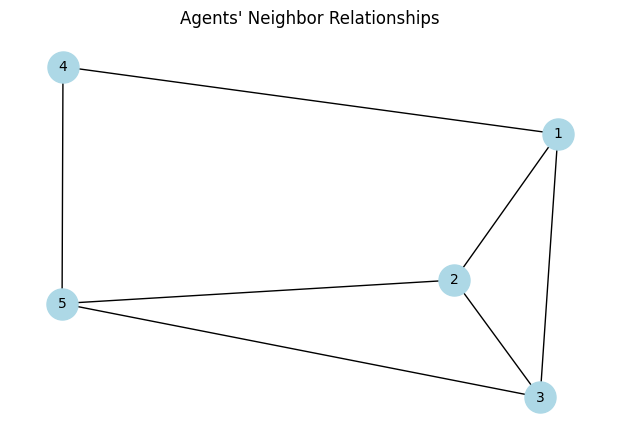

Total trigger count across all agents: 40191


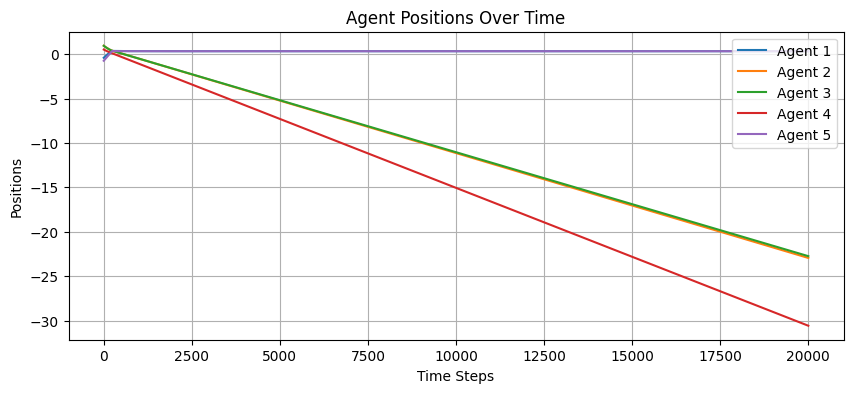

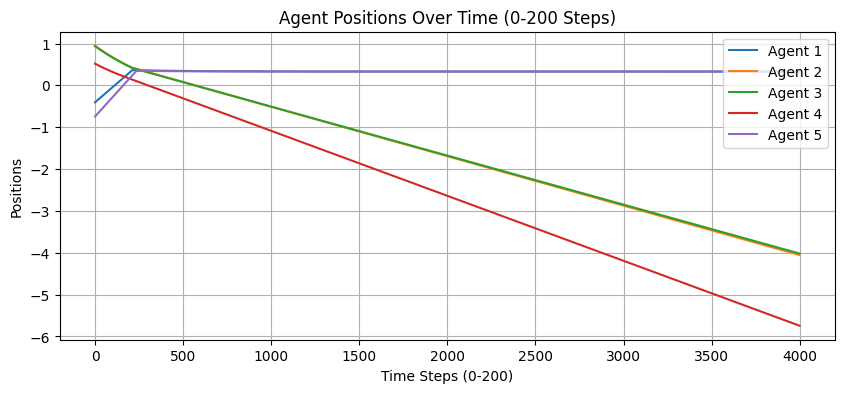

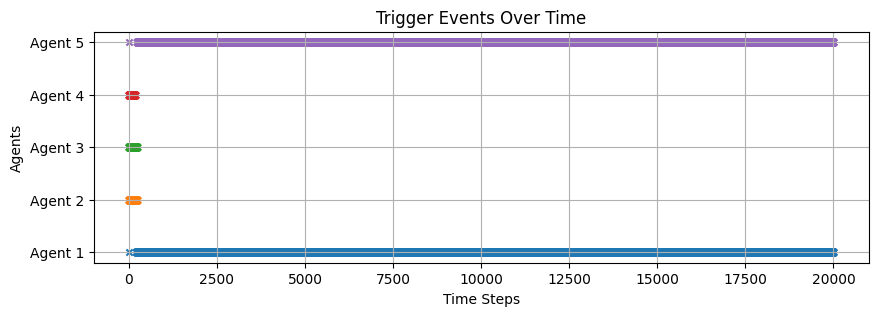

In [4]:
from matplotlib.markers import MarkerStyle
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from stable_baselines3 import PPO
from env_single1 import DistributedConsensusEnv

def simulate_and_plot(model, env, num_steps=20000):
    """模拟多个智能体的行为并绘制位置变化和触发情况"""
    # 重置环境，初始化智能体和拓扑结构
    env.reset()

    # 使用环境中的智能体列表
    agents = env.agents
    initial_positions = [agent.position for agent in agents]  # 记录初始位置
    print("Initial positions of agents:", initial_positions)
    

    # 打印并绘制智能体之间的邻居关系图
    G = nx.Graph()
    for agent in agents:
        G.add_node(agent.index + 1, pos=agent.position)
        for neighbor in agent.neighbors:
            G.add_edge(agent.index + 1, neighbor.index + 1)

    plt.figure(figsize=(6, 4))
    pos = nx.spring_layout(G)  # 使用 spring 布局进行节点位置布局
    nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=500, font_size=10)
    plt.title("Agents' Neighbor Relationships")
    plt.show()

    # 用于记录每个时间步的状态和触发情况
    positions_over_time = []
    triggers_over_time = []
    total_trigger_count = 0

    for step in range(num_steps):
        actions = []
        observations = []

        for agent in agents:
            env.main_agent = agent  # 设置当前主智能体
            obs = env.get_observation()
            # 在第一步时强制触发
            if step == 0:
                action = 1  # 强制触发
            else:
                action, _ = model.predict(obs, deterministic=True)

            # # 使用模型计算动作
            # action, _ = model.predict(obs, deterministic=True)

            # 确保 action 是标量
            if isinstance(action, np.ndarray):
                if action.size == 1:  # 如果数组大小为1，转换为标量
                    action = action.item()
                else:
                    action = action[0]  # 如果是多元素数组，取第一个元素（可以根据你的需求调整）

            actions.append(action)
            observations.append(obs)

        # 执行所有智能体的动作并更新状态
        positions = []
        triggers = []

        for i, agent in enumerate(agents):
            env.main_agent = agent  # 确保当前模拟的主智能体为 agent
            ###################################################################################################################
            env.render(actions[i])  # 执行动作，不需要捕获返回值用于模拟
            #env.step(actions[i])

            # 记录每个智能体的位置和触发情况
            positions.append(agent.position)
            triggers.append(actions[i])
            if actions[i] == 1:
                total_trigger_count += 1

        # 记录每一步所有智能体的位置和触发状态
        positions_over_time.append(positions)
        triggers_over_time.append(triggers)

    print(f"Total trigger count across all agents: {total_trigger_count}")

    # 转换为numpy数组方便处理
    positions_over_time = np.array(positions_over_time)
    triggers_over_time = np.array(triggers_over_time)

    # 绘制每个智能体的位置随时间变化
    plt.figure(figsize=(10, 4))
    times = range(num_steps)
    for i in range(len(agents)):
        plt.plot(times, positions_over_time[:, i], label=f'Agent {i + 1}')
    plt.xlabel("Time Steps")
    plt.ylabel("Positions")
    plt.legend(loc="upper right")
    plt.grid()
    plt.title("Agent Positions Over Time")
    plt.show()


    # 绘制 0-200 时间步的智能体位置变化图
    plt.figure(figsize=(10, 4))
    limited_steps = 4000  # 0-200 时间步
    times_limited = range(min(limited_steps, num_steps))
    for i in range(len(agents)):
        plt.plot(times_limited, positions_over_time[:limited_steps, i], label=f'Agent {i + 1}')
    plt.xlabel("Time Steps (0-200)")
    plt.ylabel("Positions")
    plt.legend(loc="upper right")
    plt.grid()
    plt.title("Agent Positions Over Time (0-200 Steps)")
    plt.show()



    # 绘制触发状态
    plt.figure(figsize=(10, 3))
    for i in range(len(agents)):
        trigger_times = [t for t in times if triggers_over_time[t, i] == 1]
        plt.scatter(trigger_times, [i + 1] * len(trigger_times), label=f'Agent {i + 1}', s=20, marker=MarkerStyle('x'))
    plt.xlabel("Time Steps")
    plt.ylabel("Agents")
    plt.yticks(range(1, len(agents) + 1), [f'Agent {i + 1}' for i in range(len(agents))])
    plt.title("Trigger Events Over Time")
    plt.grid()
    plt.show()

# 加载训练好的模型
model = PPO.load("ppo_consensus_d_f_single_no")

# 创建新的模拟环境
env = DistributedConsensusEnv(num_iterations=20000, dt=0.001)

# 运行模拟和绘图
simulate_and_plot(model, env)